## 4. Дисбаланс выборки

**Несбалансированная выборка (imbalanced dataset)** — выборка, в которой количество примеров каких-то классов сильно превалирует над количеством примеров других классов. Это определение также можно расширить на другие типы задач. Например, в задаче регрессии дисбалансом выборки будет ситуация, при которой распределение целевых значений будет сильно отличаться от равномерного.

### 4.1. Когда считать выборку несбалансированной?

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


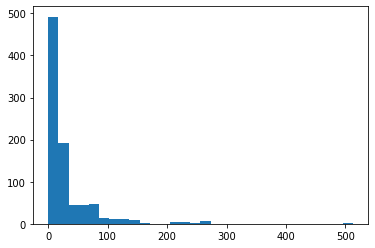

In [4]:
plt.hist(titanic['Fare'], bins=30);

<AxesSubplot:xlabel='Survived', ylabel='count'>

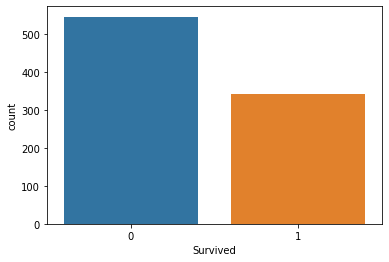

In [5]:
sns.countplot(x='Survived', data=titanic)

Нет точного определения, когда считать выборку несбалансированной. Неформально считается, что выборка несбалансированна, когда отношение количества преобладающего и минорного классов составляет 10:1.

### 4.2. Последствия дисбаланса данных

Что происходит при дисбалансе классов:
1. У алгоритма появляется склонность к более популярным классам/значениям.
1. Невозможность использования метрик, не учитывающих веса классов (базовая метрика accuracy, изученная выше, не может быть использована).

### 4.3. Решение проблемы

1. Изменить целевую метрику — в задачах классификации confusion matrix, precision, recall, F1-score, ROC-кривые будут намного корректнее описывать алгоритм, чем accuracy.
1. Изменить выборку данных: 1) oversampling — увеличение кол-ва объектов классов-меньшинств; 2) undersampling — сокращение кол-ва объектов превалирующих классов.
1. Добавить штраф в оптимизационный функционал, прямо пропорциональный кол-ву объектов каждого класса (веса классов).
1. Возможно, есть смысл перейти к задачам [Anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection) и [Change detection](https://en.wikipedia.org/wiki/Change_detection).

Во 2-м способе решение проблемы oversampling может быть выполнено как простым дублированием примеров меньшего класса, так и и более сложной техникой, называемой "аугментацией выборки".

**Аугментация выборки (data augmentation)** — процесс генерации примеров из исходных путем их модификации. Примерами аугментации данных могут служить: повороты, масштабирование изображений, применение фильтров; для текста может быть незначительно изменен контекст и изменено склонение/спряжение слов.

Еще одна техника, которая может быть использована для oversampling это **обогащение данных**. При использовании этой техники данные находятся во внешних дополнительных источниках. Например, если банк решает свою скоринговую задачу, он может также расширить свой набор данных данными другого банка при их наличии.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score

vis_data = pd.read_csv("data/train.csv", encoding = 'ISO-8859-1', low_memory = False)

In [11]:
train_data_sliced = vis_data[['fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance']]
train_data_sliced.dropna(inplace=True)

<ipython-input-11-68810d01967b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_sliced.dropna(inplace=True)


In [30]:
X, y = train_data_sliced.iloc[:, :-1], train_data_sliced.iloc[:, -1]

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.3, shuffle=False)

clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred_train)
print('[train] F1-score = {:.2f}'.format(f1_train))

y_pred_test = clf.predict(X_valid)
f1_test = f1_score(y_valid, y_pred_test)
print('[test] F1-score = {:.2f}'.format(f1_test))

[train] F1-score = 0.66
[test] F1-score = 0.58


<AxesSubplot:xlabel='compliance', ylabel='count'>

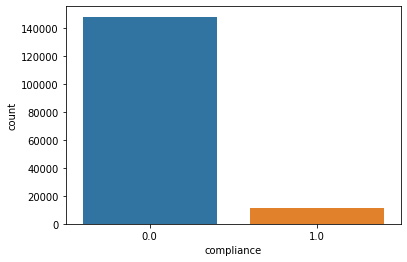

In [31]:
sns.countplot(data=train_data_sliced, x='compliance')

In [32]:
train_data_sliced.compliance.value_counts()[1]

11597

In [33]:
data_compl_0 = train_data_sliced[train_data_sliced.compliance == 0].iloc[:train_data_sliced.compliance.value_counts()[1], :]
data_compl_1 = train_data_sliced[train_data_sliced.compliance == 1]

<AxesSubplot:xlabel='compliance', ylabel='count'>

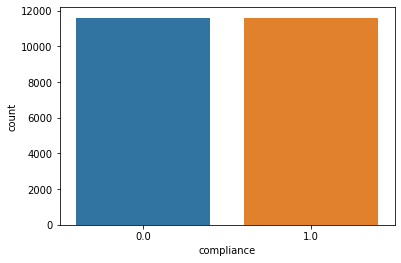

In [34]:
final_data = pd.concat([data_compl_0, data_compl_1])
sns.countplot(data=final_data, x='compliance')

In [35]:
X, y = final_data.iloc[:, :-1], final_data.iloc[:, -1]

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.3, shuffle=False)

clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

y_pred_train_balanced = clf.predict(X_train)
f1_train_balanced = f1_score(y_train, y_pred_train_balanced)
# print('[train] F1-score = {:.2f}'.format(f1_train))

y_pred_test_balanced = clf.predict(X_valid)
f1_test_balanced = f1_score(y_valid, y_pred_test_balanced)
# print('[test] F1-score = {:.2f}'.format(f1_test))

In [36]:
f1_test_balanced, f1_test

(0.7629544040529731, 0.580226904376013)